# Determining tracer-space candidate endmember variability

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────

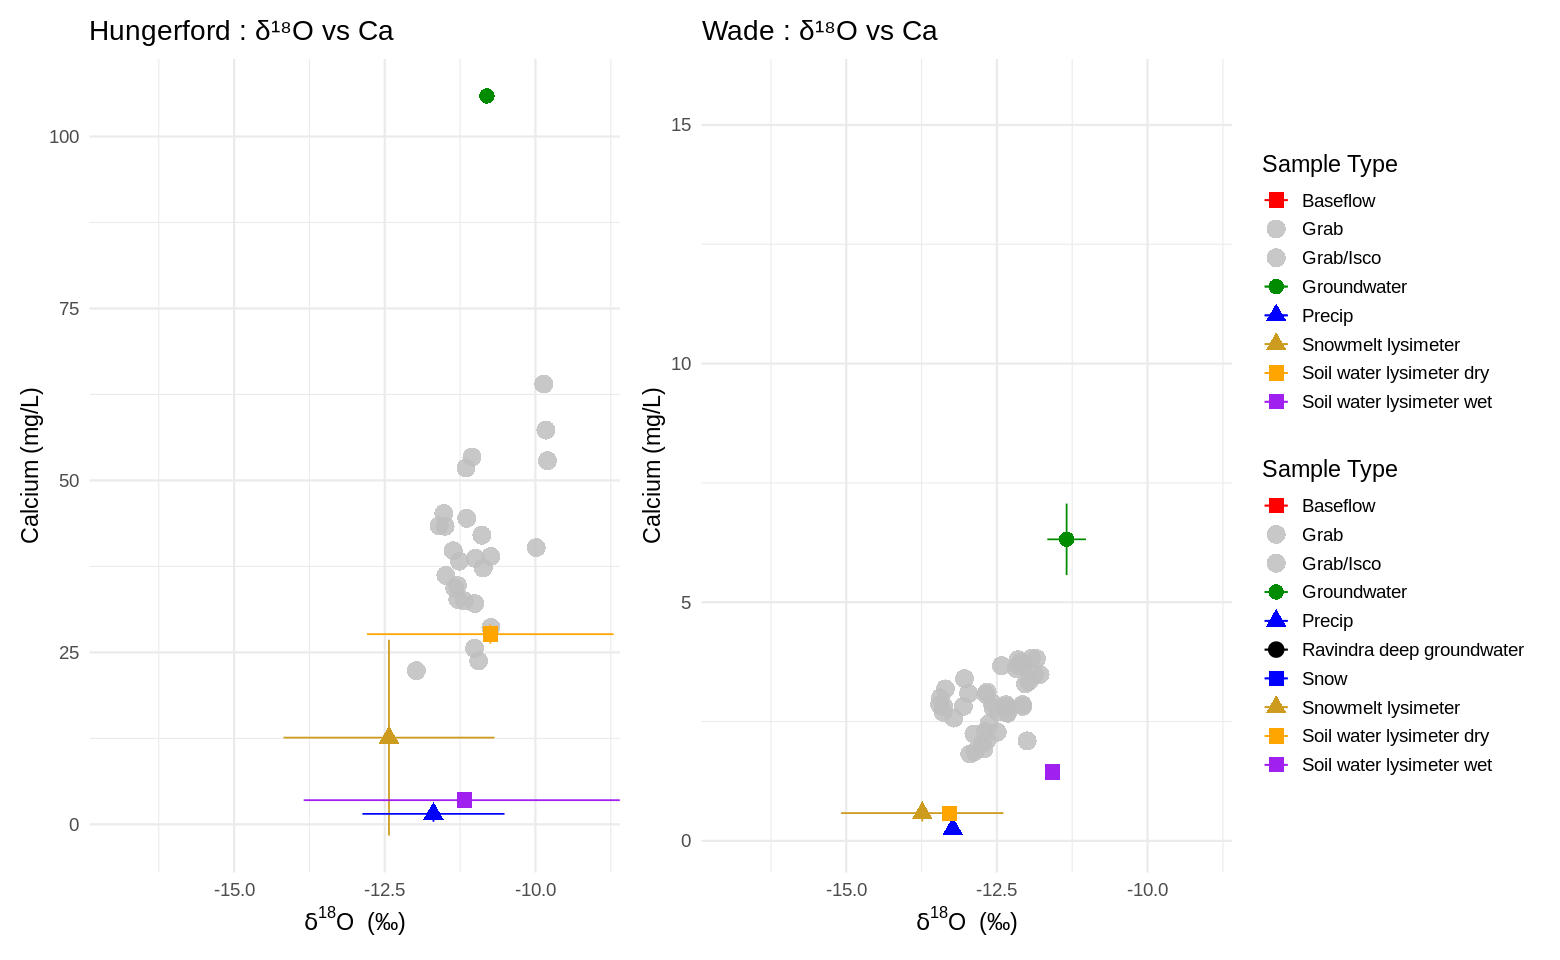

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(patchwork)

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/EMMA/")

input_dir <- "isco_metadata/LCBP_RI_sample_index/"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputData <- read.csv(file.path(input_dir, "RI23-IC-ICP-isotope-toc-joined.csv")) 

InputData <- InputData %>% # Will fix this, but some endmembers misslabeled
  mutate(Type = case_when(
    Type == "Snow lysimeter" ~ "Snowmelt lysimeter",
    TRUE ~ Type
  ))

# Convert missing values to NA
InputData[InputData == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputData$datetime <- mdy_hm(paste(InputData$Date, InputData$Time)) 

# Convert 'datetime' in InputDataQ to proper datetime format
InputData$datetime <- as.POSIXct(InputData$datetime, format="%Y-%m-%dT%H:%M:%SZ")

###################
# PLOT CA VA D18O #
###################

# Clean and filter data
InputData <- InputData %>%
  filter(!is.na(Site)) %>%
  mutate(
    Ca_mg_L = as.numeric(Ca_mg_L),
    d18O = as.numeric(d18O),
    Type = trimws(Type)
  )

# Define colors and shapes
custom_colors <- c(
  "Grab/Isco" = "grey",
  "Isco" = "grey",
  "Grab" = "grey",
  "Soil water lysimeter dry" = "orange",
  "Soil water lysimeter wet" = "purple",
  "Groundwater" = "#008B00",
  "Precip" = "blue",
  "Snowmelt lysimeter" = "#CD9B1D",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "blue"
)

custom_shapes <- c(
  "Grab/Isco" = 16,
  "Isco" = 16,
  "Grab" = 16,
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 15,
  "Groundwater" = 16,
  "Precip" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

custom_sizes <- c(
  "Grab/Isco" = 5,
  "Isco" = 5,
  "Grab" = 5,
  "Soil water lysimeter dry" = 10,
  "Soil water lysimeter wet" = 10,
  "Groundwater" = 10,
  "Precip" = 10,
  "Snowmelt lysimeter" = 10,
  "Baseflow" = 10,
  "Ravindra deep groundwater" = 10,
  "Snow" = 10
)

# Identify stream types vs endmember types
stream_types <- c("Grab/Isco", "Isco", "Grab")

# Summarize endmember types: mean ± SD for each site/type combo
endmember_summary <- InputData %>%
  filter(!(Type %in% stream_types)) %>%
  group_by(Site, Type) %>%
  summarise(
    d18O_mean = mean(d18O, na.rm = TRUE),
    d18O_sd = sd(d18O, na.rm = TRUE),
    Ca_mean = mean(Ca_mg_L, na.rm = TRUE),
    Ca_sd = sd(Ca_mg_L, na.rm = TRUE),
    .groups = "drop"
  )

# Base plotting function for a given site

options(repr.plot.width = 13, repr.plot.height = 8) 

plot_site <- function(site_name) {
  ggplot() +
    # Scatter points: stream samples
    geom_point(
      data = filter(InputData, Site == site_name, Type %in% stream_types),
      aes(x = d18O, y = Ca_mg_L, color = Type, shape = Type),
      size = 5, alpha = 0.85
    ) +
    # Error bars and points: endmember means
    geom_errorbar(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, ymin = Ca_mean - Ca_sd, ymax = Ca_mean + Ca_sd, color = Type),
      width = 0
    ) +
    geom_errorbarh(
      data = filter(endmember_summary, Site == site_name),
      aes(y = Ca_mean, xmin = d18O_mean - d18O_sd, xmax = d18O_mean + d18O_sd, color = Type),
      height = 0
    ) +
    geom_point(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, y = Ca_mean, color = Type, shape = Type),
      size = 4,
    ) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    scale_size_manual(values = custom_sizes) +
    coord_cartesian(xlim = c(-17, -9)) +
    labs(
      title = paste(site_name, ": δ¹⁸O vs Ca"),
      x = expression(delta^18*O~" (‰)"),
      y = "Calcium (mg/L)",
      color = "Sample Type",
      shape = "Sample Type"
    ) +
    theme_minimal(base_size = 14)
}

# Build plots for each site
p_hungerford <- plot_site("Hungerford")
p_wade <- plot_site("Wade")

# Combine the two
p_hungerford + p_wade + plot_layout(guides = "collect") & theme(legend.position = "right")

In [5]:
InputData

Sample.ID,Site,Date,Time,Type,Type2,Index.notes,ICP.notes,Fe_mg_L,Mn_mg_L,⋯,SO4_mg_L,IC.notes,NRS_LWIA_notes,dD,d18O,iso.notes,TOC.run.date,TOC.mg_L,TOC.notes,datetime
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dttm>
RI23-1001,Hungerford,02/9/2023,13:40,Grab/Isco,Stream,need to verify type,NA,0.070702740,0.065629733,⋯,50.594685,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-66.095,-9.827,NA,03/01/2023,26.08,NA,2023-02-09 13:40:00
RI23-1002,Hungerford,02/9/2023,16:00,Grab/Isco,Stream,need to verify type,NA,0.066423030,0.068312251,⋯,48.186849,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-66.847,-9.862,NA,03/01/2023,5.08,NA,2023-02-09 16:00:00
RI23-1003,Hungerford,02/9/2023,22:00,Grab/Isco,Stream,need to verify type,NA,0.082406714,0.052983714,⋯,45.782770,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-67.317,-9.800,NA,03/01/2023,5.79,NA,2023-02-09 22:00:00
RI23-1004,Hungerford,02/10/2023,4:00,Grab/Isco,Stream,need to verify type,NA,NA,NA,⋯,19.336434,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-72.393,-10.536,NA,03/01/2023,4.82,NA,2023-02-10 04:00:00
RI23-1005,Hungerford,02/10/2023,10:00,Grab/Isco,Stream,need to verify type,NA,0.059852160,0.036704559,⋯,33.673348,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-78.866,-11.598,NA,03/01/2023,5.34,NA,2023-02-10 10:00:00
RI23-1006,Wade,02/10/2023,13:00,Grab/Isco,Stream,need to verify type,NA,NA,NA,⋯,6.720394,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-80.253,-12.024,NA,03/01/2023,2.33,NA,2023-02-10 13:00:00
RI23-1007,Hungerford,02/10/2023,16:00,Grab/Isco,Stream,need to verify type,NA,0.082126397,0.033194773,⋯,16.175028,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-80.652,-11.977,NA,03/01/2023,6.12,NA,2023-02-10 16:00:00
RI23-1008,Hungerford,02/11/2023,12:30,Grab/Isco,Stream,need to verify type,NA,0.074341045,0.017434733,⋯,27.169938,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-75.973,-11.294,NA,03/01/2023,5.47,NA,2023-02-11 12:30:00
RI23-1009,Wade,02/15/2023,15:00,Grab/Isco,Stream,need to verify type,NA,-0.000368339,-0.013919312,⋯,8.192964,2024-10-03 MED switched SO4 and PO4 values because I think they are erroneous. Verified in Chromeleon I don't think SS knew the swap the peaks.,NA,-78.421,-11.844,NA,03/01/2023,1.95,NA,2023-02-15 15:00:00


Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Na' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Na' in 'mbcsToSbcs

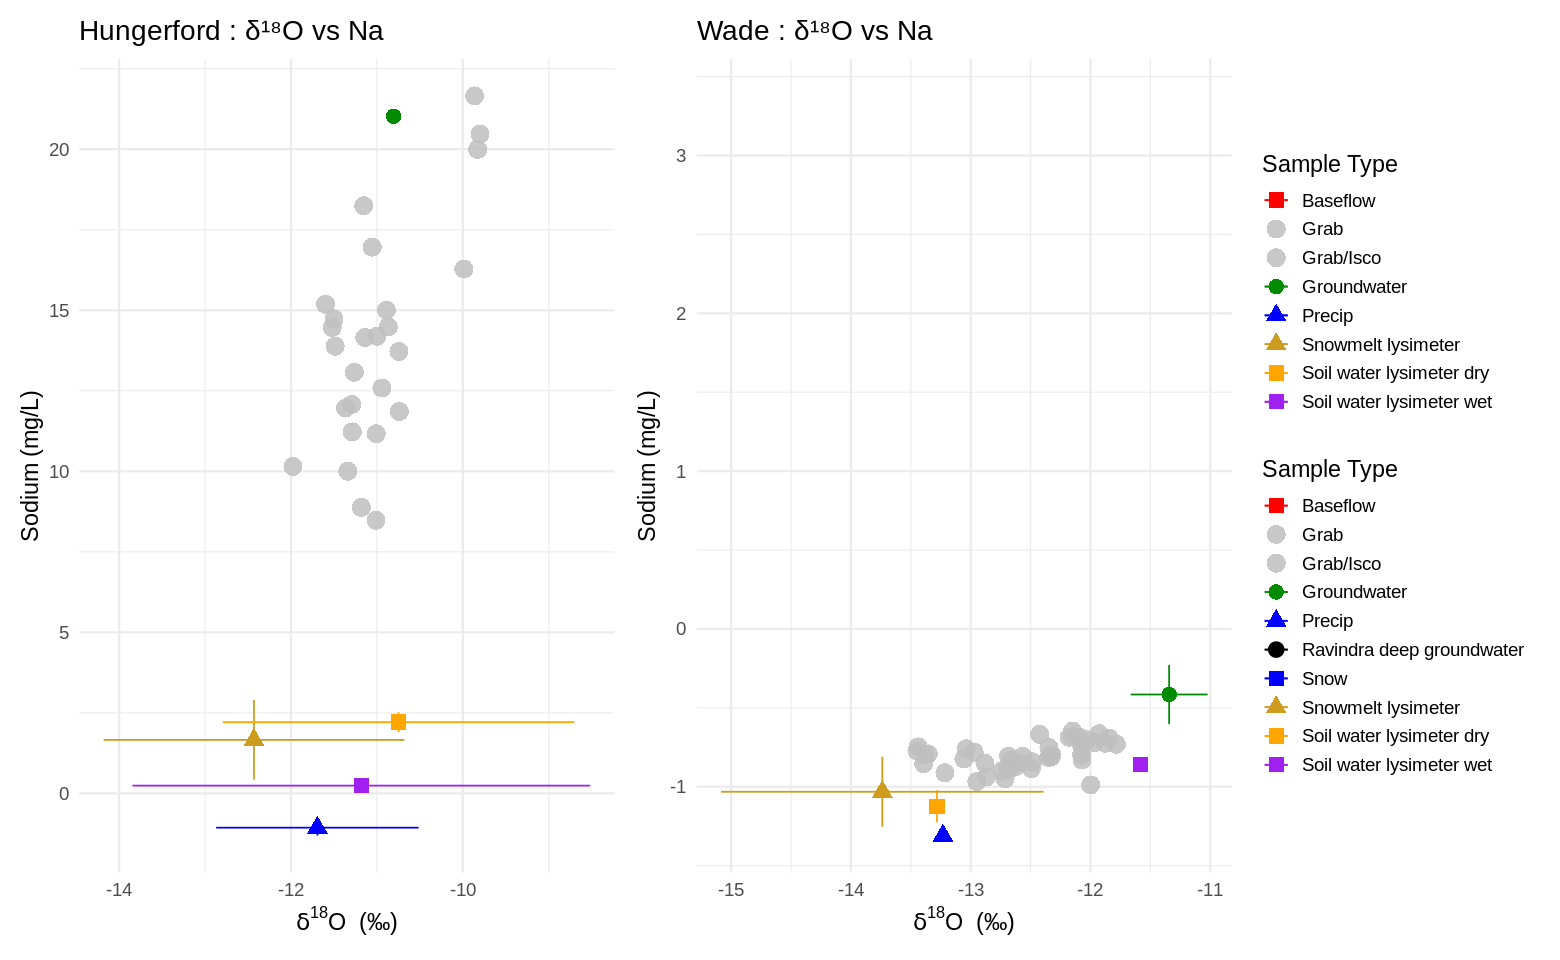

In [2]:
###################
# PLOT NA VA D18O #
###################

# Clean and filter data
InputData <- InputData %>%
  filter(!is.na(Site)) %>%
  mutate(
    Na_mg_L = as.numeric(Na_mg_L),
    d18O = as.numeric(d18O),
    Type = trimws(Type)
  )

# Define colors and shapes
custom_colors <- c(
  "Grab/Isco" = "grey",
  "Isco" = "grey",
  "Grab" = "grey",
  "Soil water lysimeter dry" = "orange",
  "Soil water lysimeter wet" = "purple",
  "Groundwater" = "#008B00",
  "Precip" = "blue",
  "Snowmelt lysimeter" = "#CD9B1D",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "blue"
)

custom_shapes <- c(
  "Grab/Isco" = 16,
  "Isco" = 16,
  "Grab" = 16,
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 15,
  "Groundwater" = 16,
  "Precip" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

custom_sizes <- c(
  "Grab/Isco" = 5,
  "Isco" = 5,
  "Grab" = 5,
  "Soil water lysimeter dry" = 10,
  "Soil water lysimeter wet" = 10,
  "Groundwater" = 10,
  "Precip" = 10,
  "Snowmelt lysimeter" = 10,
  "Baseflow" = 10,
  "Ravindra deep groundwater" = 10,
  "Snow" = 10
)

# Identify stream types vs endmember types
stream_types <- c("Grab/Isco", "Isco", "Grab")

# Summarize endmember types: mean ± SD for each site/type combo
endmember_summary <- InputData %>%
  filter(!(Type %in% stream_types)) %>%
  group_by(Site, Type) %>%
  summarise(
    d18O_mean = mean(d18O, na.rm = TRUE),
    d18O_sd = sd(d18O, na.rm = TRUE),
    Na_mean = mean(Na_mg_L, na.rm = TRUE),
    Na_sd = sd(Na_mg_L, na.rm = TRUE),
    .groups = "drop"
  )

# Base plotting function for a given site

options(repr.plot.width = 13, repr.plot.height = 8) 

plot_site <- function(site_name) {
  ggplot() +
    # Scatter points: stream samples
    geom_point(
      data = filter(InputData, Site == site_name, Type %in% stream_types),
      aes(x = d18O, y = Na_mg_L, color = Type, shape = Type),
      size = 5, alpha = 0.85
    ) +
    # Error bars and points: endmember means
    geom_errorbar(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, ymin = Na_mean - Na_sd, ymax = Na_mean + Na_sd, color = Type),
      width = 0
    ) +
    geom_errorbarh(
      data = filter(endmember_summary, Site == site_name),
      aes(y = Na_mean, xmin = d18O_mean - d18O_sd, xmax = d18O_mean + d18O_sd, color = Type),
      height = 0
    ) +
    geom_point(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, y = Na_mean, color = Type, shape = Type),
      size = 4
    ) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    labs(
      title = paste(site_name, ": δ¹⁸O vs Na"),
      x = expression(delta^18*O~" (‰)"),
      y = "Sodium (mg/L)",
      color = "Sample Type",
      shape = "Sample Type"
    ) +
    theme_minimal(base_size = 14)
}

# Build plots for each site
p_hungerford <- plot_site("Hungerford")
p_wade <- plot_site("Wade")

# Combine the two
p_hungerford + p_wade + plot_layout(guides = "collect") & theme(legend.position = "right")

Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Si' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Si' in 'mbcsToSbcs

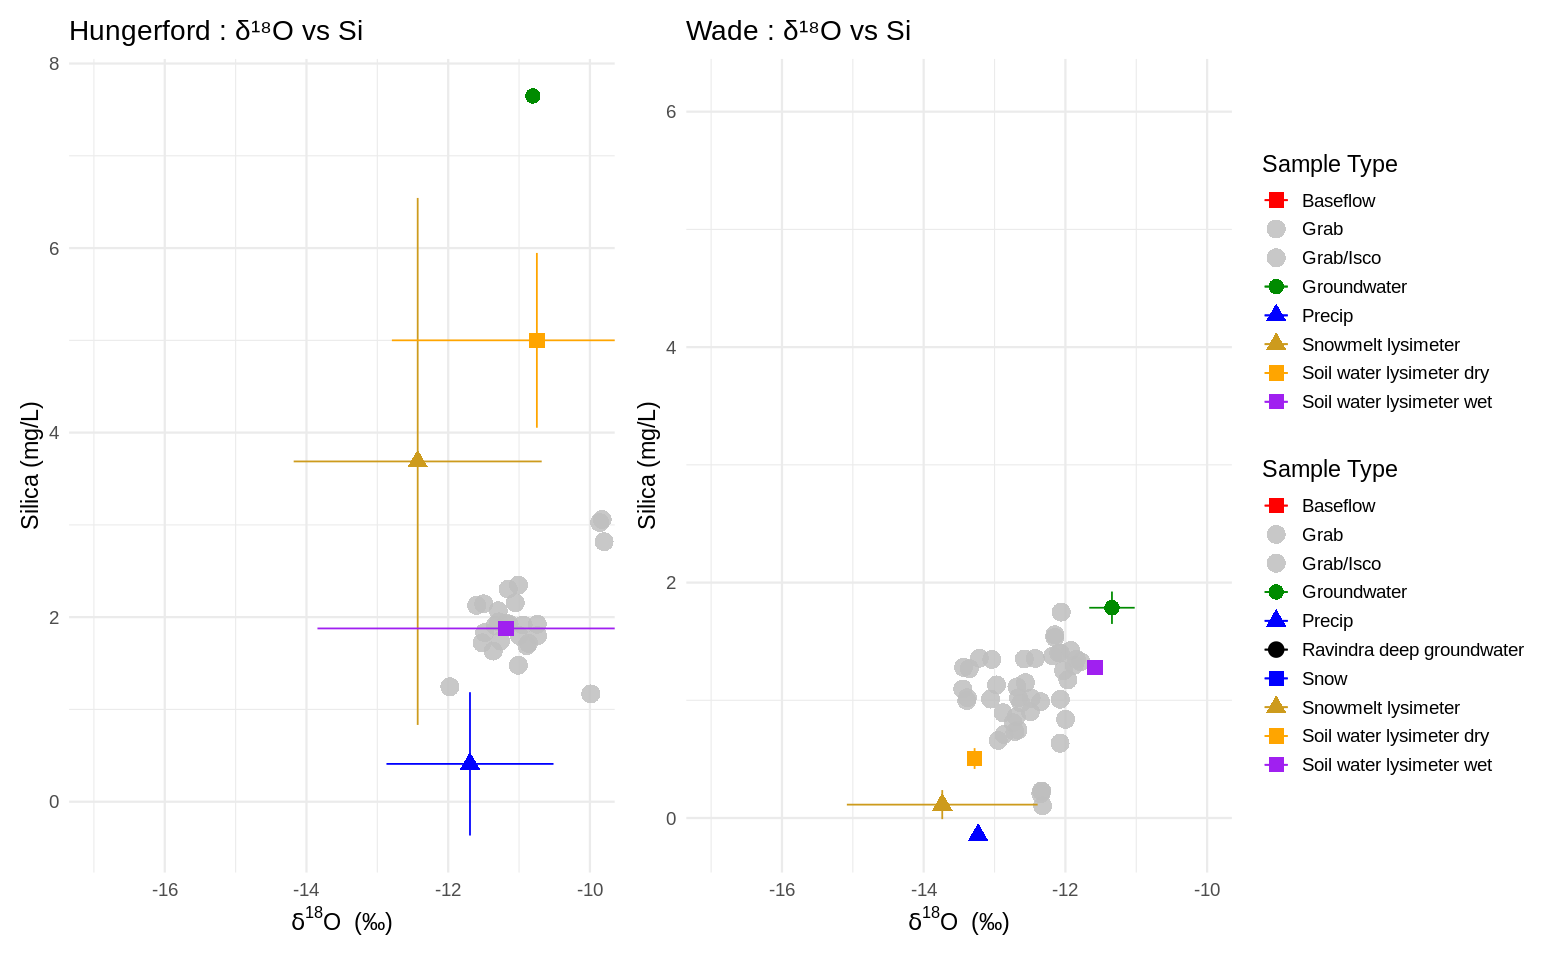

In [3]:
###################
# PLOT Si VA D18O #
###################

# Clean and filter data
InputData <- InputData %>%
  filter(!is.na(Site)) %>%
  mutate(
    Si_mg_L = as.numeric(Si_mg_L),
    d18O = as.numeric(d18O),
    Type = trimws(Type)
  )

# Define colors and shapes
custom_colors <- c(
  "Grab/Isco" = "grey",
  "Isco" = "grey",
  "Grab" = "grey",
  "Soil water lysimeter dry" = "orange",
  "Soil water lysimeter wet" = "purple",
  "Groundwater" = "#008B00",
  "Precip" = "blue",
  "Snowmelt lysimeter" = "#CD9B1D",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "blue"
)

custom_shapes <- c(
  "Grab/Isco" = 16,
  "Isco" = 16,
  "Grab" = 16,
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 15,
  "Groundwater" = 16,
  "Precip" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

custom_sizes <- c(
  "Grab/Isco" = 5,
  "Isco" = 5,
  "Grab" = 5,
  "Soil water lysimeter dry" = 10,
  "Soil water lysimeter wet" = 10,
  "Groundwater" = 10,
  "Precip" = 10,
  "Snowmelt lysimeter" = 10,
  "Baseflow" = 10,
  "Ravindra deep groundwater" = 10,
  "Snow" = 10
)

# Identify stream types vs endmember types
stream_types <- c("Grab/Isco", "Isco", "Grab")

# Summarize endmember types: mean ± SD for each site/type combo
endmember_summary <- InputData %>%
  filter(!(Type %in% stream_types)) %>%
  group_by(Site, Type) %>%
  summarise(
    d18O_mean = mean(d18O, na.rm = TRUE),
    d18O_sd = sd(d18O, na.rm = TRUE),
    Si_mean = mean(Si_mg_L, na.rm = TRUE),
    Si_sd = sd(Si_mg_L, na.rm = TRUE),
    .groups = "drop"
  )

# Base plotting function for a given site

options(repr.plot.width = 13, repr.plot.height = 8) 

plot_site <- function(site_name) {
  ggplot() +
    # Scatter points: stream samples
    geom_point(
      data = filter(InputData, Site == site_name, Type %in% stream_types),
      aes(x = d18O, y = Si_mg_L, color = Type, shape = Type),
      size = 5, alpha = 0.85
    ) +
    # Error bars and points: endmember means
    geom_errorbar(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, ymin = Si_mean - Si_sd, ymax = Si_mean + Si_sd, color = Type),
      width = 0
    ) +
    geom_errorbarh(
      data = filter(endmember_summary, Site == site_name),
      aes(y = Si_mean, xmin = d18O_mean - d18O_sd, xmax = d18O_mean + d18O_sd, color = Type),
      height = 0
    ) +
    geom_point(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, y = Si_mean, color = Type, shape = Type),
      size = 4
    ) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    coord_cartesian(xlim = c(-17, -10)) +
    labs(
      title = paste(site_name, ": δ¹⁸O vs Si"),
      x = expression(delta^18*O~" (‰)"),
      y = "Silica (mg/L)",
      color = "Sample Type",
      shape = "Sample Type"
    ) +
    theme_minimal(base_size = 14)
}

# Build plots for each site
p_hungerford <- plot_site("Hungerford")
p_wade <- plot_site("Wade")

# Combine the two
p_hungerford + p_wade + plot_layout(guides = "collect") & theme(legend.position = "right")

Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Mg' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Hungerford : δ¹⁸O vs Mg' in 'mbcsToSbcs

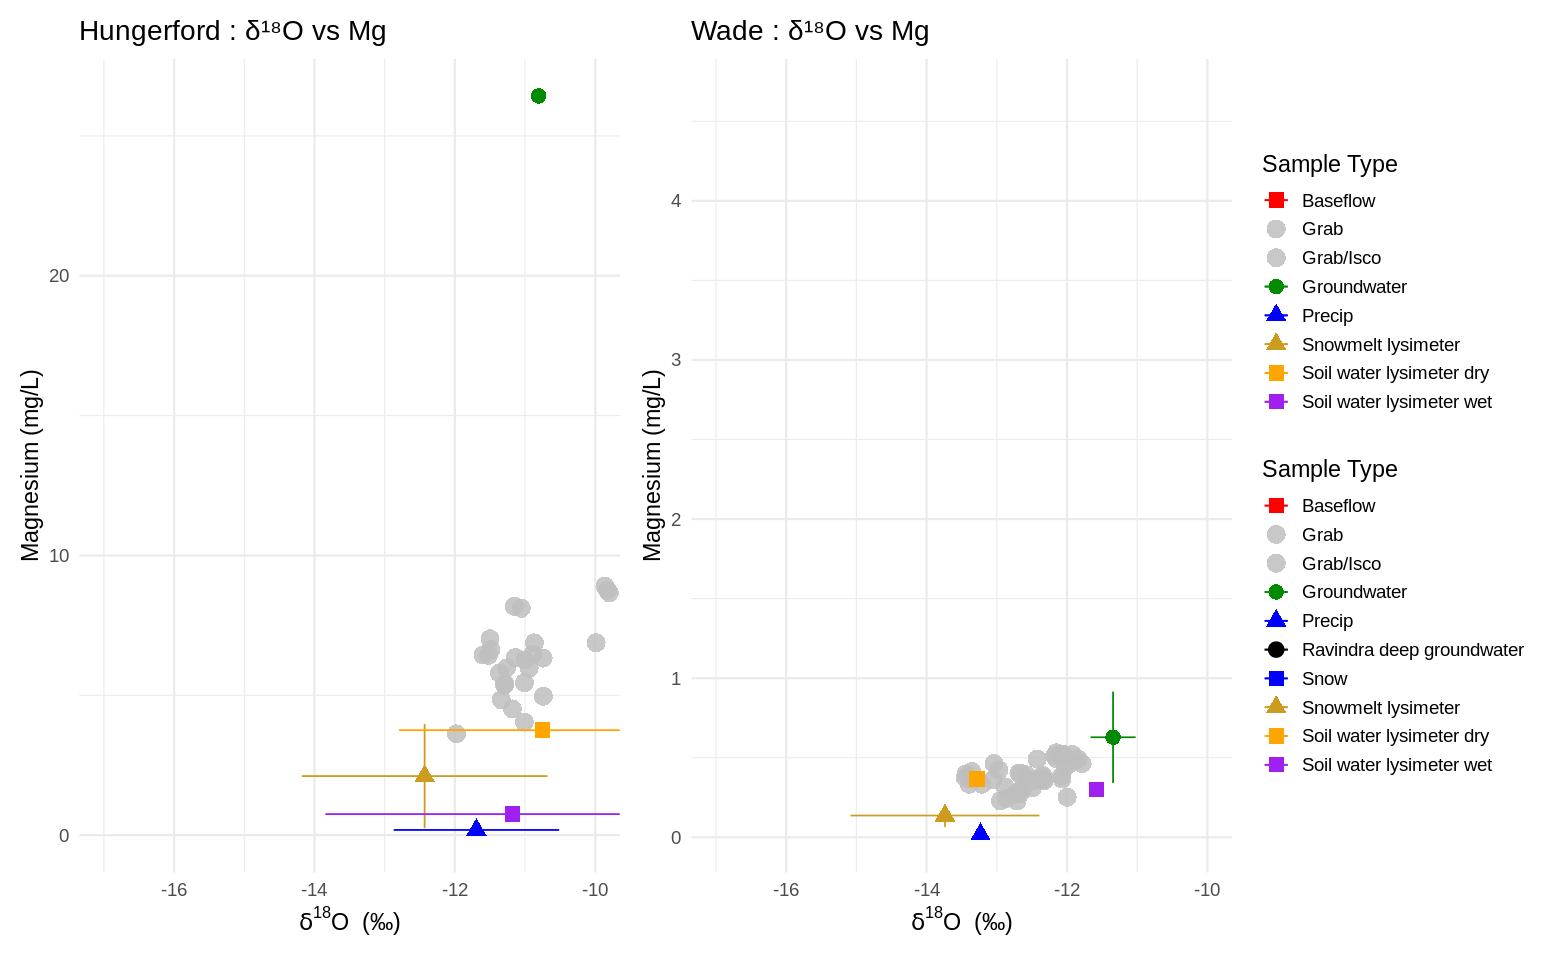

In [20]:
###################
# PLOT MG VA D18O #
###################

# Clean and filter data
InputData <- InputData %>%
  filter(!is.na(Site)) %>%
  mutate(
    Mg_mg_L = as.numeric(Mg_mg_L),
    d18O = as.numeric(d18O),
    Type = trimws(Type)
  )

# Define colors and shapes
# Define colors and shapes
custom_colors <- c(
  "Grab/Isco" = "grey",
  "Isco" = "grey",
  "Grab" = "grey",
  "Soil water lysimeter dry" = "orange",
  "Soil water lysimeter wet" = "purple",
  "Groundwater" = "#008B00",
  "Precip" = "blue",
  "Snowmelt lysimeter" = "#CD9B1D",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "blue"
)

custom_shapes <- c(
  "Grab/Isco" = 16,
  "Isco" = 16,
  "Grab" = 16,
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 15,
  "Groundwater" = 16,
  "Precip" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

custom_sizes <- c(
  "Grab/Isco" = 5,
  "Isco" = 5,
  "Grab" = 5,
  "Soil water lysimeter dry" = 10,
  "Soil water lysimeter wet" = 10,
  "Groundwater" = 10,
  "Precip" = 10,
  "Snowmelt lysimeter" = 10,
  "Baseflow" = 10,
  "Ravindra deep groundwater" = 10,
  "Snow" = 10
)

# Identify stream types vs endmember types
stream_types <- c("Grab/Isco", "Isco", "Grab")

# Summarize endmember types: mean ± SD for each site/type combo
endmember_summary <- InputData %>%
  filter(!(Type %in% stream_types)) %>%
  group_by(Site, Type) %>%
  summarise(
    d18O_mean = mean(d18O, na.rm = TRUE),
    d18O_sd = sd(d18O, na.rm = TRUE),
    Mg_mean = mean(Mg_mg_L, na.rm = TRUE),
    Mg_sd = sd(Mg_mg_L, na.rm = TRUE),
    .groups = "drop"
  )

# Base plotting function for a given site

options(repr.plot.width = 13, repr.plot.height = 8) 

plot_site <- function(site_name) {
  ggplot() +
    # Scatter points: stream samples
    geom_point(
      data = filter(InputData, Site == site_name, Type %in% stream_types),
      aes(x = d18O, y = Mg_mg_L, color = Type, shape = Type),
      size = 5, alpha = 0.85
    ) +
    # Error bars and points: endmember means
    geom_errorbar(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, ymin = Mg_mean - Mg_sd, ymax = Mg_mean + Mg_sd, color = Type),
      width = 0
    ) +
    geom_errorbarh(
      data = filter(endmember_summary, Site == site_name),
      aes(y = Mg_mean, xmin = d18O_mean - d18O_sd, xmax = d18O_mean + d18O_sd, color = Type),
      height = 0
    ) +
    geom_point(
      data = filter(endmember_summary, Site == site_name),
      aes(x = d18O_mean, y = Mg_mean, color = Type, shape = Type),
      size = 4
    ) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    coord_cartesian(xlim = c(-17, -10)) +
    labs(
      title = paste(site_name, ": δ¹⁸O vs Mg"),
      x = expression(delta^18*O~" (‰)"),
      y = "Magnesium (mg/L)",
      color = "Sample Type",
      shape = "Sample Type"
    ) +
    theme_minimal(base_size = 14)
}

# Build plots for each site
p_hungerford <- plot_site("Hungerford")
p_wade <- plot_site("Wade")

# Combine the two
p_hungerford + p_wade + plot_layout(guides = "collect") & theme(legend.position = "right")

Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


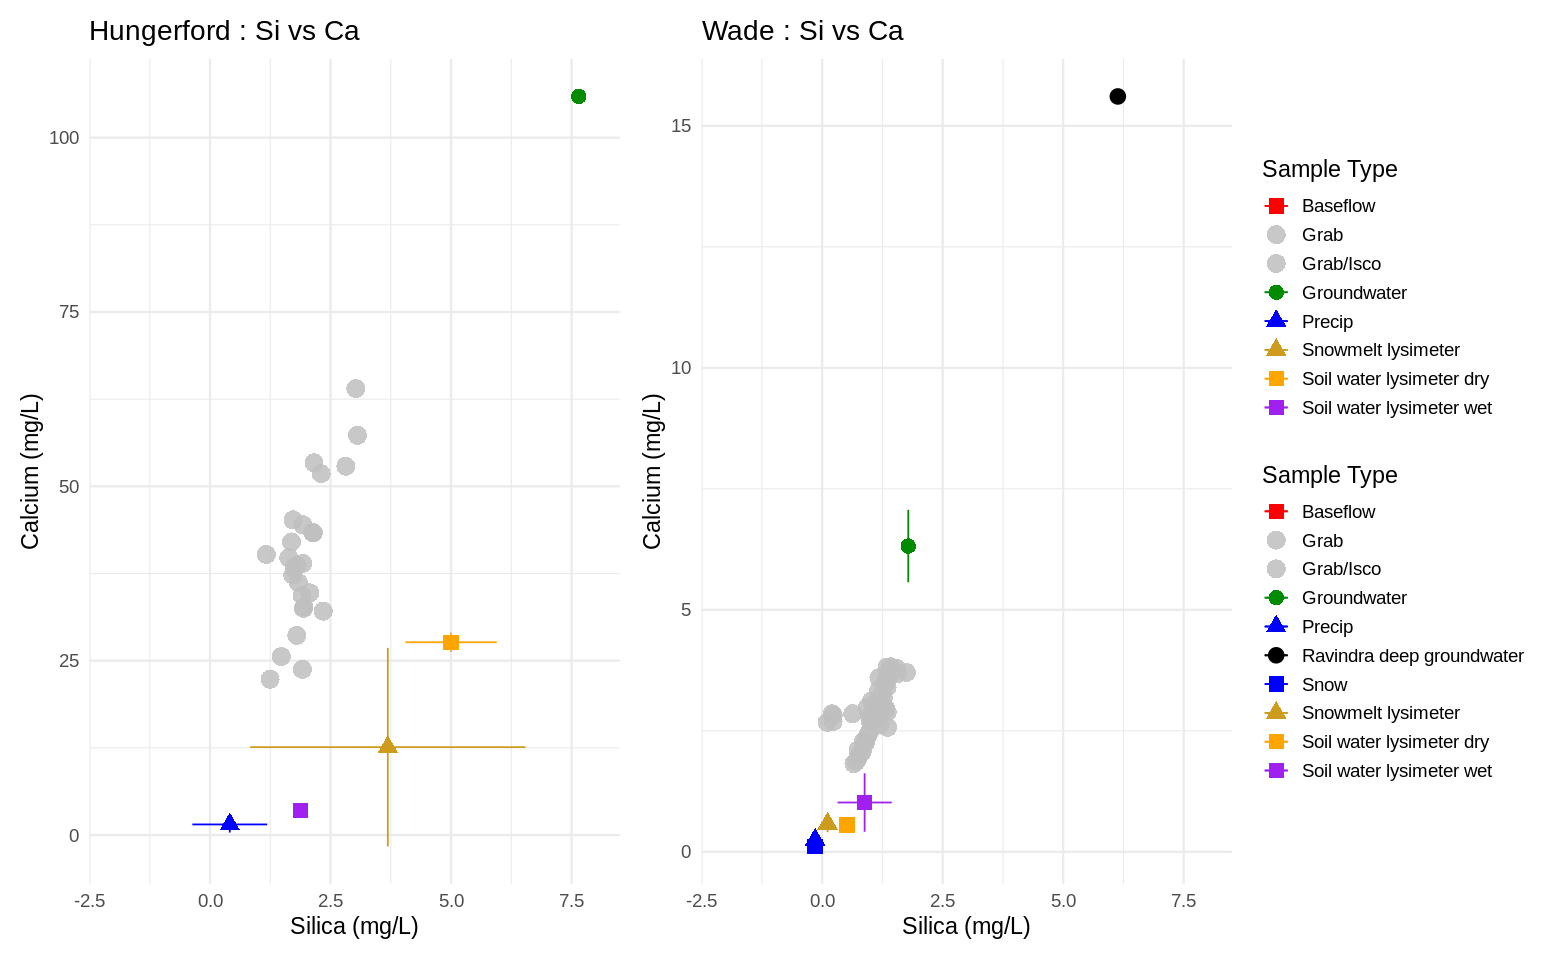

In [22]:
##################
# PLOT CA VS SI #
##################

# Clean and filter data
InputData <- InputData %>%
  filter(!is.na(Site)) %>%
  mutate(
    Ca_mg_L = as.numeric(Ca_mg_L),
    Si_mg_L = as.numeric(Si_mg_L),
    Type = trimws(Type)
  )

# Define colors and shapes
# Define colors and shapes
custom_colors <- c(
  "Grab/Isco" = "grey",
  "Isco" = "grey",
  "Grab" = "grey",
  "Soil water lysimeter dry" = "orange",
  "Soil water lysimeter wet" = "purple",
  "Groundwater" = "#008B00",
  "Precip" = "blue",
  "Snowmelt lysimeter" = "#CD9B1D",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "blue"
)

custom_shapes <- c(
  "Grab/Isco" = 16,
  "Isco" = 16,
  "Grab" = 16,
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 15,
  "Groundwater" = 16,
  "Precip" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

custom_sizes <- c(
  "Grab/Isco" = 5,
  "Isco" = 5,
  "Grab" = 5,
  "Soil water lysimeter dry" = 10,
  "Soil water lysimeter wet" = 10,
  "Groundwater" = 10,
  "Precip" = 10,
  "Snowmelt lysimeter" = 10,
  "Baseflow" = 10,
  "Ravindra deep groundwater" = 10,
  "Snow" = 10
)

# Identify stream types vs endmember types
stream_types <- c("Grab/Isco", "Isco", "Grab")

# Summarize endmember types: mean ± SD for each site/type combo
endmember_summary <- InputData %>%
  filter(!(Type %in% stream_types)) %>%
  group_by(Site, Type) %>%
  summarise(
    Si_mean = mean(Si_mg_L, na.rm = TRUE),
    Si_sd = sd(Si_mg_L, na.rm = TRUE),
    Ca_mean = mean(Ca_mg_L, na.rm = TRUE),
    Ca_sd = sd(Ca_mg_L, na.rm = TRUE),
    .groups = "drop"
  )

# Base plotting function for a given site

options(repr.plot.width = 13, repr.plot.height = 8) 

plot_site <- function(site_name) {
  ggplot() +
    # Scatter points: stream samples
    geom_point(
      data = filter(InputData, Site == site_name, Type %in% stream_types),
      aes(x = Si_mg_L, y = Ca_mg_L, color = Type, shape = Type),
      size = 5, alpha = 0.85
    ) +
    # Error bars and points: endmember means
    geom_errorbar(
      data = filter(endmember_summary, Site == site_name),
      aes(x = Si_mean, ymin = Ca_mean - Ca_sd, ymax = Ca_mean + Ca_sd, color = Type),
      width = 0
    ) +
    geom_errorbarh(
      data = filter(endmember_summary, Site == site_name),
      aes(y = Ca_mean, xmin = Si_mean - Si_sd, xmax = Si_mean + Si_sd, color = Type),
      height = 0
    ) +
    geom_point(
      data = filter(endmember_summary, Site == site_name),
      aes(x = Si_mean, y = Ca_mean, color = Type, shape = Type),
      size = 4
    ) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    coord_cartesian(xlim = c(-2, 8)) +
    labs(
      title = paste(site_name, ": Si vs Ca"),
      x = "Silica (mg/L)",
      y = "Calcium (mg/L)",
      color = "Sample Type",
      shape = "Sample Type"
    ) +
    theme_minimal(base_size = 14)
}

# Build plots for each site
p_hungerford <- plot_site("Hungerford")
p_wade <- plot_site("Wade")

# Combine the two
p_hungerford + p_wade + plot_layout(guides = "collect") & theme(legend.position = "right")

Warning message:
“Removed 16 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <b0>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Conc [mg/L] or ‰' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call.graphics(C_text, 

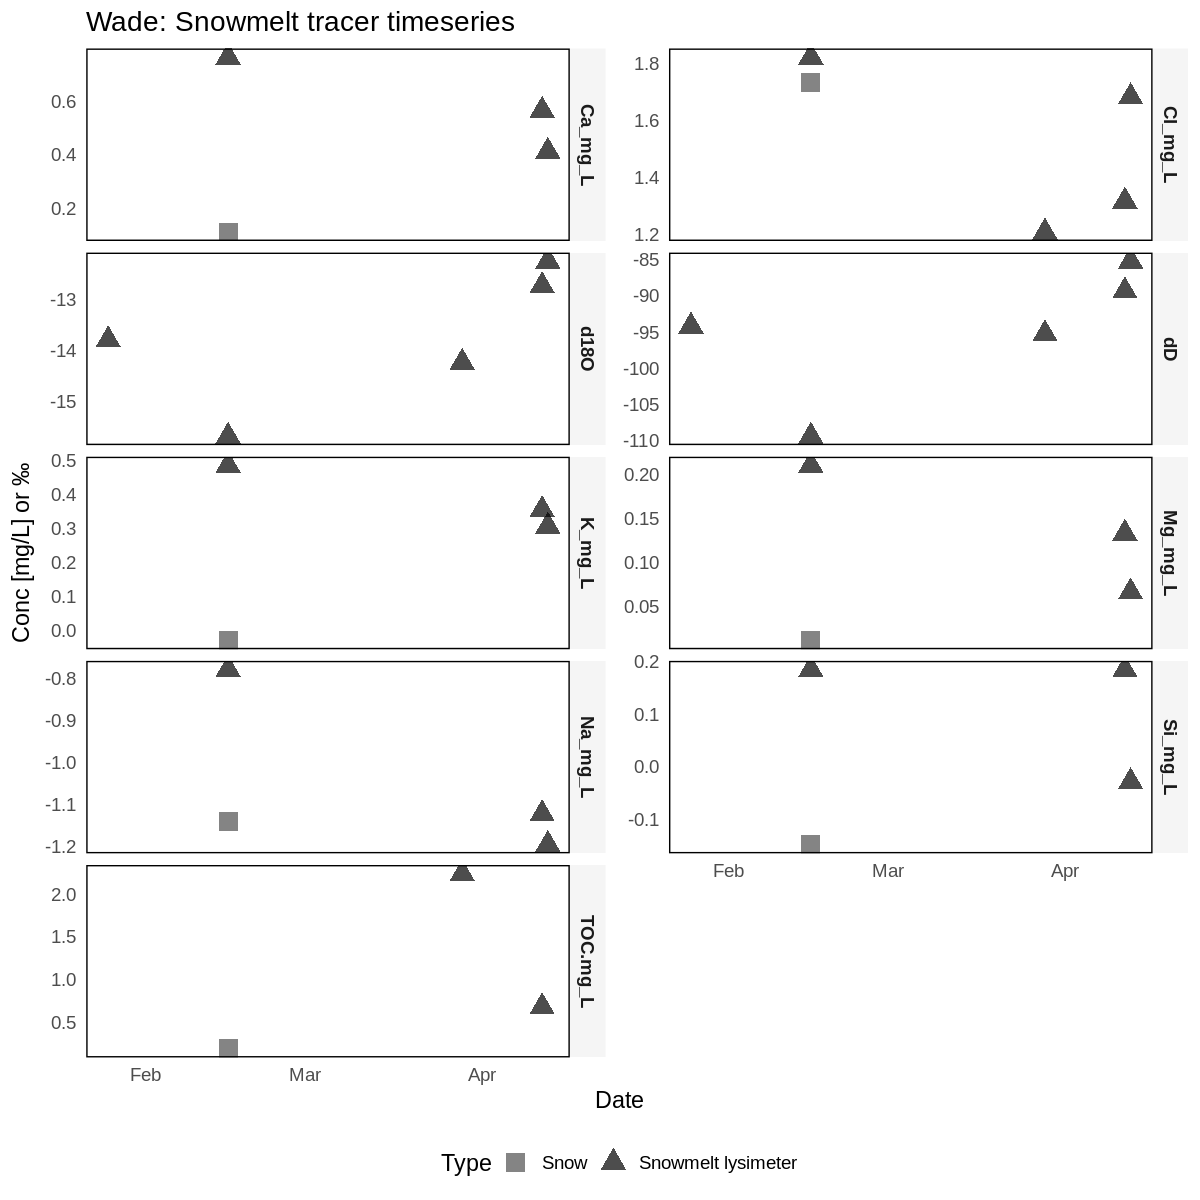

In [20]:
library(tidyverse)
library(patchwork)

# Step 1: Define tracer list and sample types to keep
tracers <- c("Na_mg_L", "Si_mg_L", "Ca_mg_L", "Mg_mg_L", 
             "K_mg_L", "Cl_mg_L", "dD", "d18O", "TOC.mg_L")

endmember_types <- c(
  #"Soil water lysimeter dry",
  #"Soil water lysimeter wet",
  "Snowmelt lysimeter",  # Already renamed from "Snow lysimeter"
  "Snow"#,
  #"Rain",
  #"Precip",
  #"Groundwater",
  #"Ravindra deep groundwater",
  #"Baseflow"
)

# Step 2: Filter and pivot data into long format
InputData_long <- InputData %>%
  filter(Type %in% endmember_types) %>%
  select(Site, datetime, Type, all_of(tracers)) %>%
  pivot_longer(
    cols = all_of(tracers),
    names_to = "tracer",
    values_to = "value"
  ) %>%
  mutate(
    value = as.numeric(value),
    Type = trimws(Type)
  )

# Step 3: Define colors and shapes (same as earlier)
custom_colors <- c(
  "Soil water lysimeter dry" = "black",
  "Soil water lysimeter wet" = "#4F4F4F",
  "Groundwater" = "green",
  "Precip" = "grey",
  "Rain" = "grey",
  "Snowmelt lysimeter" = "black",
  "Baseflow" = "red",
  "Ravindra deep groundwater" = 'black',
  "Snow" = "#4F4F4F"
)

custom_shapes <- c(
  "Soil water lysimeter dry" = 15,
  "Soil water lysimeter wet" = 17,
  "Groundwater" = 16,
  "Precip" = 17,
  "Rain" = 17,
  "Snowmelt lysimeter" = 17,
  "Baseflow" = 15,
  "Ravindra deep groundwater" = 19,
  "Snow" = 15
)

# Step 4: Plotting function per site

options(repr.plot.width = 10, repr.plot.height = 10) 

plot_tracer_timeseries <- function(site_name) {
  InputData_long %>%
    filter(Site == site_name) %>%
    ggplot(aes(x = datetime, y = value, color = Type, shape = Type)) +
    geom_point(size = 5, alpha = 0.70) +
    scale_color_manual(values = custom_colors) +
    scale_shape_manual(values = custom_shapes) +
    facet_wrap(~ tracer, scales = "free_y", ncol = 2, strip.position = "right") +
    labs(
      title = paste0(site_name, ": Snowmelt tracer timeseries"),
      x = "Date",
      y = "Conc [mg/L] or ‰"
    ) +
    theme_minimal(base_size = 14) +
theme(
  panel.grid = element_blank(),                 # Removes all grid lines
  strip.text = element_text(face = "bold"),
  legend.position = "bottom",
  panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),  # Boxes around facets
  strip.background = element_rect(fill = "#f5f5f5", color = NA)              # Optional: soft background behind facet labels
)
}

# Step 5: Create plots for each site
plot_hungerford <- plot_tracer_timeseries("Hungerford")
plot_wade <- plot_tracer_timeseries("Wade")

# Optionally: Display them one after the other
plot_wade
